<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 200
testBlockSize = 400
numVars = 5
numYs = 1
numPoints = 200
target = 'Skeleton'
const_range = [-2.1, 2.1] # constant range to generate during training only if target is Skeleton
decimals = 8 # decimals of the points only if target is Skeleton
trainRange = [-3.0,3.0] # support range to generate during training only if target is Skeleton
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "1_5_var_dataset"

In [20]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [21]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 2262058 examples, 44 unique.
id:1166655
outputs:C*x1**5+C*x1**4+C*x1**3+C*x1**2+C*x1+C>__________________________________________________________________________________________________________________________________________________________________________
variables:1


In [27]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)[:maxNumFiles]
textTest = processDataFiles(files)
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 953 examples, 44 unique.
tensor(-4.2290) tensor(2.9988)
id:332
outputs:C*log(C*(C*log(C*x1+C)))/2+C>________________________________________________________________________________________________________________________________________________________________________________
variables:1


In [23]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np
from sympy import sympify, Symbol, sin, cos, log, exp


def validate_prediction(
    skeleton, variables=["x1", "x2", "x3", "x4", "x5"], constant_symbol="C"
):
    local_dict = {var: Symbol(var) for var in variables}
    local_dict[constant_symbol] = Symbol(constant_symbol)

    local_dict.update(
        {
            "sin": sin,
            "cos": cos,
            "log": log,
            "exp": exp,
        }
    )

    try:
        expr = sympify(
            skeleton, locals=local_dict, evaluate=False, convert_xor=True
        )
    except Exception as e:
        return False

    return True

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton

            #if not validate_prediction(predicted_skeleton):
            #    continue

            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                continue
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                continue
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)

            # Compute error and store results
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [24]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: 1.6570892466721525*sqrt(-0.5481326790673482*abs(1.029360105369968*exp(-0.8537850684620862*x1)))+-0.06686977578231623
Predicted: 1.0*x1+1.0*x1)+1.0
Err:100.0
----------

Target: -1.2833791093669282*cos(1.4602318194529205*x1**2)+-0.021363508693039268
Predicted: 1.0*x1+1.0*x1)+1.0
Err:1410.2850022299099
----------

Target: -0.5501530530534955*x1+1.7388398212520957*x2+0.4983779125550072*sqrt(1.9321876241814988*abs(-0.41686455969038017*x3+-1.5994829411524583))+-1.9542293324224058*exp(-0.30557966564090955*cos(0.7090139064127676*x4+-1.2742106498924506))+0.381760141297244
Predicted: -0.06736231388921267*x1+0.11770838921685625*x4+-0.0052393656999121935
Err:0.8446003721216475
----------

Target: -1.6506575705017281*x2**4+-0.6749133427018499*x2**5+-1.3449190505698465*x2**4+0.5358471126635944*x2**3+0.683236962485215*x2**2+-0.4968320756733231*x2+-1.4753413240008482*exp(1.5591275383113699*x4)+1.1929425857863012
Predicted: 1.0*x4**5+1.0*x4**5+1.0*x4**3+1.0*x4**3+1.0*x4+1.0+1.0*1.0+1.0*1.0*1.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.8709916103772635*sqrt(-2.0843138874550844*abs(-1.7456860879241929*x2))+0.14041656375262646
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: 1.8098449150739175*cos(-0.6666956735026206*x1+1.9652388628985)+0.11364062724593049
Predicted: 0.724061555672007*x1+-0.36036740378744864
Err:0.7246596461426715
----------

Target: 0.3109184070575508*sqrt(0.9595507965603205*abs(1.5032986544847122*log(1.7470029006455574*x2+-0.3659898564754531)))+-2.0067131416639863
Predicted: 1.0*x2(1.0*x2)+1.0
Err:717.3718094655749
----------

Target: 0.07654274882948009*abs(-0.8744284845687413*x3+1.665679628241739)**3+-1.2278060997601787
Predicted: 1.0*x3+1.0*x3)+1.0
Err:421.6902770535742
----------

Target: 1.6832636088992037*cos(0.8829289176283908*cos(1.981681641427524*x2+1.379810928435206))+2.085201536967539
Predicted: 1.0*x2+1.0*x2)+1.0
Err:546.0382700243039
----------

Target: -1.828634855327925*x1**2+1.6696509275894393
Predicted: -1.828642195967033*x1**2+1.5119365951367613e-05*x1+1.669645

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.4914366135290962*log(0.14720624993119946*log(-0.5475699989500655*x2/x1)+1.3989933130185848)+1.2876377195420967
Predicted: 1.0*x2(1.0*x2)+1.0
Err:681.2090633398186
----------

Target: -0.5800656837141585*x1+-1.5506054871454855*x3+-0.0315520700355596
Predicted: 0.09236981201586027*x2+-0.9587151124082244*x3+-0.1485414977833925
Err:0.1530113343325763
----------

Target: -1.9434463237917239*x2+1.4387325019917756
Predicted: -1.9434463382826486*x2+1.4387324993453494
Err:4.32367786448079e-17
----------

Target: -1.6289289474414184*log(0.7380613271096652*sin(1.0395004925287163*x3*x4))+1.8963930405641296
Predicted: 1.0*exp(1.0*x4*+1.0
Err:370.5132994162944
----------

Target: 0.8309687341383167*log(-1.0082611204452074*x2+1.2135523930771233)+-0.6699663668898452
Predicted: 1.0*x2+1.0*x2)+1.0
Err:1413.16964417005
----------

Target: -0.6860515557744127*exp(-0.5921937636697603*x2)+-0.6055138700116895
Predicted: 1.0*x2(1.0*x2)+1.0
Err:198.08627926956166
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.9186159908323184*x1/x2+0.09701130674627656
Predicted: 0.014002332380358565*x2/1.3486251868095018+0.060501875687277204
Err:0.1353107383254946
----------

Target: -0.37646539995982464*x1*x2+-1.6174839612680776*x1*x4+0.3754597580655834*x1+1.743166992719782*x2+-0.972643730092418*x3+-1.5794540428926982*x4+0.9084505738810393
Predicted: -0.04281977315906475*x4**2+-0.1184676675423051*x4+-0.11846771748896155*x4+0.21735210788545736*0.21735210788545684+0.21735210788545542*0.21735210788545645+0.02724918059059681
Err:2.3451663099061815
----------

Target: -1.0269817243474504*x1+0.5719968623419711*x2**3+2.055524603815934*log(0.2083493739318163*sin(-1.0237220019815905*x4))+0.43224732869520466
Predicted: -0.0008119097478886812*x1**x4+0.20866997724749986*x4+-1.5973656112321972
Err:4.635605436596034
----------

Target: 1.2995669021125984*exp(0.5326051144447668*x3)+-1.2486223403149697
Predicted: 0.31527857652600455*x3+0.3152785799188759*x3++0.12771900061960964
Err:0.31657307449271355
--------

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.9675622286256305*sin(-1.0504436869053693*x1+1.3741386038908026)+1.83000929187008
Predicted: 1.0*cos+1.0*x1)+1.0
Err:567.7972924965156
----------

Target: -0.07399584470690623*x1**3+0.6999169756858121*x1**2+1.708498879723106*x1+1.4526424605121782*x3+-1.335621155265682
Predicted: 2.825869365628922*x1+1.4602987885754923*x3+-1.432565668897402
Err:0.042196935689287264
----------

Target: 1.4651015148417632*x2**2*-1.3527090854349066*sqrt(0.7825053253821466*abs(1.312893681490364*sqrt(0.37282550674844783*abs(0.7571253745611277*x1))))+0.48242376732762526*x2+-0.5552134591972895
Predicted: -1.5466763808344723*x2**2+0.6460770976326774*x2+-0.5862217954815269
Err:0.19886841316621984
----------

Target: 1.3957992986695653*x1+-0.8663678538875812
Predicted: 1.3957993358162712*x1+-0.8663678738475081
Err:3.598494508541681e-16
----------

Target: -0.4596819882076757*x2+-0.6851303587919821*x3**4+-0.9736111881595686*x4+-0.12156222337412093
Predicted: -0.010312606015300747*x4**5+-0.222411334655189

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.8498303044136712*x3*x4+-1.5723213710155282*x4**4+1.0133466842957768
Predicted: 1.0*x4**5+1.0*x4**1.0+1.0*x4**3+1.0*x4+1.0+1.0*x4+1.0+1.0+1.0+1.0+1.0+1.0+1.0*1.0+1.0+1.01.01.01.01.01.01.01.01.01.01.01.01.01.01.01.01.0+1.0+1.01.01.01.01.01.0*1.01.01.01.0*1.0*1.01.01.01.01.0*1.0*1.01.0**1.0**1.01.01.0*1.01.01.0*1.01.0***1.01.01.01.0*1.01.01.0*1.0*1.01.01.01.0*1.01.01.01.01.01.0**1.0**1.01.01.0*1.01.0***1.01.01.01.0***1.01.01.01.01.01.0*1.01.01.0**1.0*1.0*1.0*1.01.01.0*1.0*1.0*1.01.01.01.0*1.01.01.01.01.0**1.01.01.01.01.0*1.0***1.0
Err:59.093353735553684
----------

Target: -1.7576995558929305*x1*x2+1.4416612975517298*x2+-1.3613644018003477
Predicted: 0.11615825085745862*x2**2+0.04864458694370526*x2+-0.10655973422093419
Err:2.1849902398434256
----------

Target: 0.3296851264710998*sqrt(0.7190482149931419*abs(-1.5261255522206003*x4+-1.1245331206206988))+2.0757034365894484
Predicted: 1.0*cos(1.0*x4*+1.0
Err:447.84009027450844
----------

Target: 1.9304300156053196*x4+1.3515397959

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.8829420990164727*exp(1.0531472220817717*cos(-0.4466758547647116*x2))+-1.973830860953903
Predicted: 1.0*x2(1.0*x2)+1.0
Err:2006.9426448335378
----------

Target: -1.193792707369718*x2*x4+-0.787510459693239*x2+-0.5137841237094549*x4+-1.317003009557591
Predicted: 0.02478795774438439*x1**x4+-0.08355143822789583*x4+-0.37489233470311106
Err:2.838297837870982
----------

Target: 1.5540839352292628*x2**3+2.094461407928406
Predicted: 0.20294454929113082*x2**5+1.5923498617209968
Err:88.5814308530469
----------

Target: -1.597750938286191*x3*x4+-1.3340806507551117*x3+-0.13818088596016675*x4+-1.215371286730572
Predicted: -0.008527365927625626*x1**x4+-0.08449318917466167*x4+-0.43335698100491227
Err:2.818710148789161
----------

Target: -1.5131050863659246*x3+1.0147884389693003*x4+-0.848177742995716
Predicted: 0.11765483527184421*x1+0.2939226283480752*x4+0.3264401341113262
Err:1.1927963841643265
----------

Target: 1.2808342345867758*cos(-1.4835683043058938*exp(-0.7982851232035684*x2))+1.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.590722456653344*x2+0.9826541479288426*x3**5+-1.2577542346342578
Predicted: 1.0122451300552078*x3**5+-0.49971265216143973*x3+0.8636715872734271*0.8636715872734271*0.37491808409034827**3+0.4003522363517726*0.40035223635177253+-0.42892578549817
Err:0.2636328423049794
----------

Target: -0.5141921303186985*x2+-1.8579030193433121*x3+2.0687379559637376
Predicted: -0.5141912109878302*x2+-1.8579027436216464*x3+2.068737390149377
Err:2.1673505165062653e-13
----------

Target: 1.5616964724292872*log(-0.9028355914241588*x1+-1.9235183781515093)+-1.3438926285801518
Predicted: 1.0*x1+1.0*x1)+1.0
Err:2121.54483503851
----------

Target: -1.958270027429979*x1+-0.27625590241762454*x3+1.092723921959868
Predicted: -1.9582700607787489*x1+-0.2762561559242677*x3+1.092723661720617
Err:1.099497189729663e-14
----------

Target: -0.629130364741592*x3/(0.016592712999155435*x3+-0.3314219499538411)+2.090755631604257
Predicted: -0.020983567923298498*x1+1.849983418457554*x3+2.2205057910568833
Err:0.03305

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.342828836302687*x2+-0.4851572885296964*x3+0.5375016898593632
Predicted: -0.0037866471146928643*x1+-0.06480151606673475*x3+-0.05783092921312013
Err:0.4958496302412516
----------

Target: 1.45414522218914*x1+1.691588715220631*x4+0.9543132386499185*sqrt(0.12025166209605898*abs(-1.5942229411463575*x3+1.2208493497693702))*-0.06902681613967054*cos(0.3462501595276075*x3+-1.9385718462284574)+-0.1932965497177217
Predicted: 0.2304001754297648*x1+-2.504910181426766+2.200123008036773*2.200123008036772+-2.5049101814267645
Err:0.9089825533036235
----------

Target: -2.0898631140300816/x2+-0.9376874145006213
Predicted: -0.568477466634808*x2/1.657085783084718+-0.6671268475528448
Err:0.06677315760959053
----------

Target: 0.8946605951378976*log(0.0994291008220487*x4)+-0.7004859163178585
Predicted: 1.0*cos(1.0*x4*+1.01.0*x4+1.0+1.0)+1.0
Err:1153.043663905993
----------

Target: -1.414184516750238*x1*-1.5958618589873819*exp(-0.7274217436198493*x1)*0.6861474005583421*cos(0.5130899262809705*x4/

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.4657325038711382*x1/(1.4993898853650358*x1+2.065596455007318)+1.4913738056036543
Predicted: 1.0/x1(1.0*x1)+1.0
Err:399.4793437930978
----------

Target: -1.2626820403165806*x1**3+0.19713036851275012
Predicted: -0.6929569113857896*x1**3+213.32638695188064*x1**2+-213.75483992304967*x1**2.0051739411534304
Err:0.060767032155370264
----------

Target: -1.2222534245223677*x1**4+1.1862859364351648
Predicted: 1.0*x1**5+1.0*x1**5+1.0*x1**4+1.0*x1**3+1.0*x1+1.0+1.0*x1+1.0+1.0*1.0*1.0*1.0*1.0*1.0*1.01.01.01.01.01.0x11.01.01.01.0x11.01.0*x11.01.01.01.01.01.01.01.0*1.01.01.01.01.01.01.0*1.01.01.0*1.01.0*1.01.01.01.01.01.0*1.01.0*1.01.0*1.01.0**1.01.01.01.01.01.01.01.01.01.01.01.01.0*1.0******1.0*1.01.0**1.01.0*1.01.01.0**1.01.0***1.01.01.01.0*1.01.01.0*1.0***1.01.01.0*1.01.01.01.01.01.01.01.01.01.0*1.01.0*1.01.01.01.01.0*1.01.01.01.01.01.01.01.0**1.0*1.01.01.01.01.0*
Err:43.36987317836869
----------

Target: 1.5397721694570348*cos(-1.462446614430878*x1+1.6475738829276576*sqrt(-0.72785688

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.6078214887545554*x1**5+-0.826484365701182
Predicted: 1.0*x1**5+1.0*x1**5+1.0*x1**4+1.0*x1**3+1.0*x1+1.0+1.0*1.0+1.0+1.0*1.0+1.0*1.0*1.0*1.0*1.01.01.01.01.01.0x11.0x11.0*x11.01.0*1.01.01.01.0*1.01.01.01.01.01.01.01.01.01.0*1.01.0**1.0**1.0****1.0***1.01.0*********x11.0***1.0*****1.0*1.0***1.01.0*1.0*****1.0**1.0*1.01.0***********1.0***1.01.0**1.0**1.0*****************1.0**************1.0*****
Err:342.83540165672184
----------

Target: -1.0214480832386117*sin(0.7235297346421015*x1+0.478360119128002)+0.8787255021713731
Predicted: 1.0*cos+1.0*x1)+1.0
Err:1976.4478198700356
----------

Target: 1.5158114674894834*sin(-0.5503023207396773*cos(1.582973730403332*x1**3))+-0.7403072353606264
Predicted: 1.0*cos+1.0*x1)+1.0
Err:862.5104945825998
----------

Target: 0.8079502414126551*x1**4+-1.3280858105407258*x1**3+1.6648970935538765*x1**2+1.18781142634759*x1+0.4505634469991082
Predicted: 0.8081082299929199*x1**4+-1.3294703853894982*x1**3+1.6654233341486353*x1**2.001089359511994+1.1885066

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.698977158183295*x3+0.1740764166995592*exp(1.7196703496046255*x5)+0.9363751177388311
Predicted: -0.21222419866086123*x5**-0.28714171095206925+0.34576546293738064*x5+0.6049079779167492
Err:22.314734223906328
----------

Target: -1.6824077626185394*log(-0.14630405353766496*x2+-1.5300076722581555)+-0.0394794325972283
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.6326351194188025*x1*-1.4887257115716679*log(0.6034318556672211*x2+-0.07560162764650924)+-1.9552022944200371*x2+1.2346428904373736
Predicted: -1.6870130257935105*x2+1.0994311507854804
Err:0.15527475002677704
----------

Target: -1.9023342016136837*x2+-1.8802771152797535*x4+-1.7506306549634563
Predicted: -0.05317451919928241*x1+-1.1737801203619669+1.0727316893297103*1.0727316893297099+1.0727316168288201*1.0727316168288212+-1.1737801203619682
Err:0.7453609970600442
----------

Target: 1.6306132306608303*x1**2+1.0845274935828115*x1+0.48384889352802407
Predicted: 1.6306446777553858*x1**2+1.0844578987649311*x1+0.48383549424889793
Err:2.140436200541701e-10
----------

Target: -1.0707906485853746*x1+-1.2461357673732325*x4+1.697634198765397
Predicted: -1.070790692682149*x1+-1.246135829394596*x4+1.6976342569378282
Err:1.5399592357559958e-15
----------

Target: 1.0460218666762389*x2*x4+-1.3209040594148624*x2+0.4098174007252955*x4+-0.19286987380730625
Predicted: -0.0005008918441814117*x

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.28942191064906586*x2+-1.6359796432897835
Predicted: 1.0*x2(1.0*x2)+1.0
Err:428.78127156824905
----------

Target: 0.16699724929770232*x2**4+-0.056754964222380355*x2**3+-0.49156874495499614*x2**2+1.0889467853246857*x2+0.4663392084200968*sin(-1.9956093748286228*x5+0.8853292371761254)+-0.15029063349132787*exp(0.03442122907699563*sin(-0.5677977973294692*x4+-1.408609267603746))+-1.4171482753255704
Predicted: -0.0411748060835875*x5**x5+0.04198820042415069*x5+-0.2842867573001386
Err:4.88070722637152
----------

Target: 1.567140252956054*sqrt(1.3052853271003375*abs(1.4835331215224117*exp(-0.10821733047620374*x5)))+0.8652798199896372
Predicted: 1.0*cos(1.0*1.0*x51.01.0)x5+1.0
Err:318.00254125447884
----------

Target: -1.6018419059370748*log(0.5020705619736727*x3)+-1.6962676126732787
Predicted: 1.0*log+1.0*x3+++1.0
Err:571.3448180374315
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.1095126221971303*cos(0.8109166224932762*exp(-1.6474622790147002*x2))+1.9958293974283206
Predicted: 1.0*x2(1.0*x2)+1.0
Err:525.4055404642207
----------

Target: -0.7103251987642809*x5/(1.8004588960832715*x1+0.9748275915451803)+0.7826064188907553
Predicted: 0.011927545998986237*x5/1.5633238522390358+0.6437245623676511/++2.0307031554128288
Err:0.03488332419698498
----------

Target: -0.7763285272062732*x1+-0.09651454459899744*x2+-1.620874567235337
Predicted: 0.06098177688794151*x2+-0.4513242413215201
Err:0.4265302382563864
----------

Target: -1.8614279666721585*exp(1.9931909159535253*cos(-0.8681406636175093*x4))+-0.6925830636719423
Predicted: 1.0*(1.01.0*1.0*x41.01.0+1.0+1.0+)+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0
Err:1189.0611487930507
----------

Target: 1.173062839189166*x3+0.1202564122368539*x5+-1.9698206720464342
Predicted: 0.07045288681815624*x5+-0.48729989997121914
Err:0.8631362998957322
----------

Target: 0.8526508027087565*x2*x5+1.3296522830125181
Predicted: -0.0074525

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.5915557209270883*x4+-1.1185593396308686
Predicted: -6.650333712342864e-09*x1+1.591555718607984*x4+-1.118559341500772
Err:1.115282219392042e-17
----------

Target: 1.2305509180258016*x1*x5+-2.088449702746889
Predicted: 0.0033320875964669297*x4**x5+0.06901957336191213*x5+-0.5887338948585398
Err:1.999182426397521
----------

Target: 0.8871363044606575*exp(0.5710334672809667*x1)+-1.4258383773769858
Predicted: 1.0*x1+1.0*x1)+1.0
Err:159.30876160063167
----------

Target: -1.4047995281829069*x4*x5+-1.207633622854709*x4+1.7950744729350352*exp(0.8994375909203853*x4)*1.5921489260474035*log(-0.484597819045532*exp(0.9078606976263437*x3))+1.3810815980199127
Predicted: 0.026865364711980116*x5**5+0.47521582895797737
Err:100.0
----------

Target: 1.7334984741783495*x1**3+0.09819113457498485*x1**2+1.4519593185257156*x1+1.910856501961367
Predicted: -2.5528743079173907e-06*x1**4+1.7335097155680645*x1**3+0.09817798142866369*x1**2+1.451963642232278*x1+1.910855455649319
Err:5.216943771074885e-11

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.4906475203048186*x4**4*-0.9612454815856386*sqrt(0.3795073733450338*abs(-0.8350575074368225*x2+1.1529277370098616))*-1.817764217430873*sin(-1.085414282113695*exp(0.6718507968269121*x2))+0.02074754788545574
Predicted: 1.0*exp**1.0+1.0)+1.01.0*1.0+1.0*1.0+1.0
Err:37.58139286292382
----------

Target: -1.043014437770875*x4+1.7849468496901353*x5+0.3404912736913128
Predicted: -0.13669317290310037*x1+0.7676454979999072*x5+-0.16043501783864028
Err:0.4034234361304732
----------

Target: 0.4863826294924283*x2+0.9433486319314959
Predicted: 1.0*x2+1.0*x2)+1.0
Err:333.8421986518336
----------

Target: 0.8935954841514482*log(1.286597536467931*x4+-0.5661647287252052)+0.7731414571656927
Predicted: 1.0*cos+1.0*x4)+1.0
Err:862.5020790036041
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.0994291008220487*sqrt(-0.7004859163178585*abs(-0.1910014986519566*sin(-1.5040638554684516*x2)))+-0.8523054698611385*cos(-0.1677743878080391*x1+1.6215814067795087*x2+-2.058240556143237)+-1.7336496753188448
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -1.780692448405884*x2+1.4417858960146632
Predicted: -1.7806924498512278*x2+1.4417858930836223
Err:1.2332898370907838e-18
----------

Target: 1.7685547721600665*cos(-2.019350256006232*log(-0.5077483712916551*x1))+0.4214163091037997
Predicted: 1.0*x1+1.0*x1)+1.0
Err:1319.8438118209938
----------

Target: 0.2331726056055472*x3**5+1.9000086278419528*x3**5+1.6926520850428064*x3**4+1.4865485507276297*x3**3+-0.3103860004569514*x3**2+-1.8637601770080852*x3+-1.1149421315518047
Predicted: 1.0*x3**5+1.0*x3**5+1.0*x3**4+1.0*x3**3+1.0*x3**1.0+1.0*1.0+1.0*1.0*1.0+1.0*1.0*1.0+1.0*x31.01.01.01.01.0*1.01.01.01.01.01.01.01.0+1.01.01.0*1.01.01.01.01.01.01.01.01.01.0*1.01.01.01.01.0*1.0**1.01.0****1.0*1.0***1.0***1.0***1.0**1.0*****1.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.2983187317767011*x2+1.2978642853702813
Predicted: 1.0*x2(1.0*x2)+1.0
Err:888.1315466738114
----------

Target: 0.6798786662061667*x1+0.7795407515768953
Predicted: 1.0*x1+1.0*x1)+1.0
Err:1043.320100272057
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.7353570254544284*cos(-1.4126366235361072*log(-1.1746265841868777*x2+1.7943010304272415))+-0.26273007781406665
Predicted: 1.0*x2(1.0*x2)+1.0
Err:3891.351164761641
----------

Target: -1.4164740470054547*log(0.003197294903177106*x2**3+1.1835645247733302*x2**2+-1.6307134894850372*x2+1.587170959100129)**3+-0.44989686866128653
Predicted: -0.37546582494701747*x2/1.370445785804711+-0.9501170759391153
Err:14.142115604906525
----------

Target: -0.7814172372071724*log(0.1858242462468649*x1*x2+0.17578382942048165*x1+-0.8246996807549409*x2+1.2748564976031882)+-2.0193238685610004
Predicted: 1.0*x2(1.0*x2)+1.0
Err:559.5840068537135
----------

Target: -0.6513866863009028*x2+-0.7659657554930175
Predicted: -0.6513867190046135*x2+-0.765965796514046
Err:7.590739626285421e-16
----------

Target: 1.7305978683969698*x5+-0.38549122352690524
Predicted: 1.7305978984575552*x5+-0.38549113093153525
Err:2.5778238502262525e-16
----------

Target: 1.9473033703601295*x1**2+-0.20038116469068967*cos(1.715

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.5137397381445608*x1**3+-1.5369722257633152
Predicted: 1.0857830129788004*x1**2+-1.9519540201599237
Err:0.8014857267230825
----------

Target: 0.747990386463055*x1**3+-1.014121205790557
Predicted: 0.7479903778502656*x1**3+-1.0141211973074407
Err:2.125838014323509e-15
----------

Target: 0.20328429774491985/-0.18152772444651966*log(0.7581911003935375*x2)+1.1700969336557607
Predicted: 1.0*x2(1.0*x2)+1.0
Err:7701.543184842005
----------

Target: 1.676037679842847*log(0.08973973860720097*exp(-0.05969593682970453*cos(1.4217371795703353*x1)))+-0.019015113728486632
Predicted: 1.0*exp(1.0*1.0*+1.01.0*1.0+1.0)1.0)+)
Err:245.6918669025139
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.9828734193638802*x1**3+1.611669175293673
Predicted: 0.9828734105470286*x1**3+1.6116691494283775
Err:4.954608818361536e-16
----------

Target: -1.197787119667064*log(-0.26803042739311755*x1/(1.499283757548255*x1+1.9072477681485887)+0.3659400309595191/(-0.19925012280208088*x1**3+1.7126088261720867*x1**2+-0.04371473643868562*x1+1))+-1.8457189944169214
Predicted: 0.47859383085287194*x1+-0.14613619673947476
Err:100.0
----------

Target: 0.8709381458250984*x1+1.7710545238746498*x2+-1.631978113911157
Predicted: 0.870938093043449*x1+1.7710544442578513*x2+-1.6319780708079334
Err:1.6570432800000584e-15
----------

Target: x1+-1.4089440211956101
Predicted: 0.9999999982279074*x1+-1.4089440338223485
Err:3.3593728427037333e-18
----------

Target: 1.9227094802999756*x1/0.2486118992790587*sqrt(0.7670531131783846*abs(0.24537387139705347*x2+-1.991766922226063))+0.5274288096966964
Predicted: -2.3278750699860913*x2**3+846.8115968217327*x2**1.0198750456029595+-848.3286405594251*x2+2.149267598854

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.8670719729843952*sqrt(-2.0870421612874046*abs(-0.5088637832007241*x2))+0.7205538804589127
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -0.44764861533724276
Predicted: 0
Err:0.04799404130706925
----------

Target: -1.4816358549989612
Predicted: 0
Err:0.10665120235083518
----------

Target: -0.5794375484429479*x1/(0.6376132044774354*x1+1.786497311125982)+0.38469610206622784*x2*-1.7866177358376143*sin(0.6749867007263002*x1)+-0.45948183754985683*sin(1.6790661135923535*x1+-0.5837926229783346)+0.8570664671588202
Predicted: -0.38711401426116887*x2/1.195066336189518+0.4347067673494837
Err:0.27060933923795766
----------

Target: -1.8637138178026702*log(1.7411963681123468*x2+-0.27710300929458787)+-0.1288534907915968
Predicted: 0.24880472208853954*x2+-0.17500364071180638
Err:0.7414850502395215
----------

Target: 1.8951181655400795*log(-1.447327281287537*x2)+1.0559079950983103
Predicted: 1.0*x2+1.0*x2)+1.0
Err:501.1061273369413
----------

Target: -0.7354393538672173*x1

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.3269091986275403*x1+1.108937991858808*x2+-0.43958992263851937
Predicted: 0.8429796996354046*x2+-0.4561345046662054
Err:0.05651780493323717
----------

Target: -1.009981613506402
Predicted: 0
Err:0.08009754507318011
----------

Target: -1.4513861404076716*x2**3+1.8489480152602944*x2**2+0.8343307230253538*x2+1.283390169521879
Predicted: -0.19165742506215652*x2**3+0.6232181297121188
Err:4.683383511546557
----------

Target: 0.05976571616812976*x1+0.8438958970803254*log(-1.2921220540895364*x2+0.852821160255754)+-1.1634878285700592
Predicted: 1.0*x2(1.0*x2)+1.0
Err:4389.752263558651
----------

Target: -1.9291992050414164*x1+0.3005249471572111
Predicted: -1.9291990703280217*x1+0.3005249799693927
Err:4.376615640296523e-15
----------

Target: -0.8194426728099926*exp(-1.370770221674153*sin(1.60178542038522*x1+-0.759884572242356))+1.0138405380864688
Predicted: 1.0*cos+1.0*x1)+1.0
Err:1580.7522778123882
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.588703883282089*abs(0.046056734441162206*cos(0.7755103049933965*x2))**2+-1.4389552742691922
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1053.623527055165
----------

Target: -0.7413910488964697*x1**2+0.5673230295738825*x2+-1.9978582197413173
Predicted: -1.8950846399971633*x1+-1.098156185910911+x2+-1.098156185910911
Err:0.23585340578111813
----------

Target: 1.544077161903092*cos(-1.6114286867418302*x1*x2+1.2989362140920098*x1*-1.553992535755535*sin(-0.29909075339528024*x1))+-1.7788569213226908
Predicted: -0.008806906588498954*x2+-0.7329334256650287
Err:0.07810285022652541
----------

Target: -1.0213998877558337*x1+1.7302384675074642
Predicted: -1.0213998603322993*x1+1.730238495998925
Err:2.4083335771184613e-16
----------

Target: -2.062108288698014*exp(-0.951158297870486*sin(-0.8889835547120477*log(-1.2124804856459392*x2)+1.4188708581731406))+-1.0018490996208922
Predicted: 1.0*x2(1.0*x2)+1.0
Err:661.0782705706605
----------

Target: 0.13386652009928302*x1*x2+-1.1625758472981076*x1+0

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.7705568767172015*x1+-0.8544929018420395*x2+0.3275373986703647/-0.1369114109998799*log(-0.9539346533313053*x2)+1.6740542589572995
Predicted: 0.17657851674806446*x1+0.2269293302983811+x2+0.226929330298381
Err:1.2014331918396761
----------

Target: -1.0647740328790383*sin(0.7363616485081819*log(1.686232484623023*x2+1.3233719716514085))+0.745319837364498
Predicted: 1.0*x2(1.0*x2)+1.0
Err:4110.684026052117
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.566457911247825*x2**4+1.395441722541365
Predicted: 0.5664579032680763*x2**4+1.3954417061034887
Err:2.8372248053577365e-15
----------

Target: 1.6685825182327498*sin(2.0598941051092488*x2**2)+0.8294529438847791
Predicted: 0.018457780021072227*x2+0.13185867389196784
Err:0.11237218996953026
----------

Target: -0.7912923440676196*x1+1.505536661764658*x2+0.018658193158316294*cos(0.7581546483727708*x1+-0.16621219992683955)+0.8545924862754064
Predicted: -0.2806602104025725*x1+0.39785316796890785
Err:0.4655444155498999
----------

Target: 0.5344411596792504*x1+-0.05887849427503422
Predicted: 1.0*x1+1.0*x1)+1.0
Err:442.26584820037624
----------

Target: 0.28351304677538636*x1+1.2641517592970635*x2+-0.11345044410795979
Predicted: 1.0527057228598549*x2+-0.33648181207770866
Err:0.04090280229245132
----------

Target: -0.9209543058711847*x2/(1.8999153435491558*x2+-1.897687478750042)+0.03527090663099619
Predicted: 1.0*x1(1.0+1.0)++1.0
Err:1596.7769142986992
----------

Target: -1.3833116

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.3240496475293273*sin(-1.3597803316988315*x1)+1.1909329293041684
Predicted: 1.0*x1+1.0*x1)+1.0
Err:799.6542895647152
----------

Target: 0.22490895603726457*x1**3+-0.4206350925442002*x1**2+-1.9398685915060219*x1+-0.38211700300049456
Predicted: -1.6928894016594402*x1+-0.32864573014596954
Err:1.5912881234417748
----------

Target: 0.867830082466996*x2+-1.0828490120603398
Predicted: 0.8678296544149592*x2+-1.0828484540403074
Err:1.3478218446463238e-13
----------

Target: -1.2061216150430674*x1*x2+-1.7416189177812658*x1+-0.5775338248040933
Predicted: -0.16468374584995735*x2**x2+0.38393609321410105*x2+0.2600264558637937
Err:65.71829653350689
----------

Target: -0.7678609443017832*x1+0.5417506429474623*x2+-2.0085304249364966
Predicted: 0.16356538633286263*x2+-0.24189900768500894
Err:0.2528074901284585
----------

Target: 1.8629076288843507*log(0.7120078575847182*abs(-1.6424428054790645*x2+1.4639416714235498))/2+1.5664253874185987
Predicted: 1.0*x2+1.0*x2)+1.0
Err:679.5641286309038

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.0079453382255394*log(-1.3072269508728316*x2/(-1.9448336273971532*x2+1.378387139224945)+0.4619391812228959/(-0.3933219512629842*x2+-0.6491487565702245))+1.7661191466208757
Predicted: 0.22697096433085415*x2+0.5891055127153955
Err:0.13435433374553746
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.7310853700793523*log(-0.7656062181876078*exp(-0.1920296977327638*x2))+0.9233215773517625
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -0.6392626665730963*x1**2+0.8088008949915468*x1+0.8786207358711615*x2+-1.9261063220106474
Predicted: 0.6160460637485071*x2+-1.322319350316065
Err:0.5525601747293385
----------

Target: 1.3251857394650224*exp(0.08417928642999817*x1)*1.193184539654542*sin(1.8351014879861425*x2)+-0.0979142621461313
Predicted: -0.07730211203760814*x2+-0.05558375512613671
Err:0.15253745230223467
----------

Target: -1.5677935606388242*x1+1.6492212563207769*x2+2.0715034647556316
Predicted: 0.7031086267871887*x2+0.7608823879029849
Err:0.5035711540757632
----------

Target: -0.9182836963363223*sin(-1.1278300872325295*x1**4*x2)+-0.6153973829950381
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1161.6970673562203
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.6850093255139607*x1*x2+1.5584960668594103*x1+-1.6942594550714705*log(1.7608202421471244*x1)+1.7914011512065642*cos(1.2169673860103938*exp(1.753507376674155*x2))+-0.1558852791614349
Predicted: 0.3766648456473598*x1+-0.7389721203618894+x2+-0.7389721203618894
Err:3.1182548711129563
----------

Target: 0.5216055681007297*x2+1.7846619576641451*sin(0.5559839697502706*sqrt(-0.6595759430793287*abs(-0.6110137046206303*x1+1.807989675250496)))+-1.1627077937212655/x1+-1.923136174630966
Predicted: 1.0*x2+1.0+1.0)++1.0
Err:100.0
----------

Target: -2.063085574725493*log(-1.7808238121360696*x1*x2+1.1564773166274311*x1+2.052314961944941*x2+-0.7590905641325429)+-0.6421309157314721
Predicted: 0.27381751565558426*x2+-0.7344818344097506
Err:0.6732641563010215
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.05843618210340029*log(0.7182092840003245*cos(1.4318937288505103*x1+1.9780553575102888))+0.4047667742549703*sin(0.15442956144219*x1+2.0130293506228987*x2+1.0502054369119813)+-1.0592191747582023
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1745.0576018578558
----------

Target: -2.0264543642011255*x2**5+0.4793339225515263
Predicted: 1.0*x2**5+1.0*x2**5+1.0*x2**4+1.0*x2**3+1.0*x2+1.0+1.0*x2+1.0*1.0+1.0*1.0*1.0*1.01.01.0*x21.01.01.01.01.0x21.0x21.01.0x21.01.0x2x21.0x21.0x2x21.01.0x2x21.0x2x21.0x21.0x2x2x2x2x2x21.01.01.01.0x21.01.0x2x2x2x2x2x2x2x2x21.0x2x2x2x2x21.0x2x2x21.0x2x2x2x2x2x2x21.0x2x2x2x2*x2x2x2x2*x2x21.01.0x21.0x2x2x2x2x2x2*1.0x2x2**x2*x2x2x2x2x2x2*x2x2x2x2x21.0*1.0x2x21.01.0x2x2x2x2x2**1.01.0x2x2x2x2x2*x21.0x2x21.0x2**x21.0x2x2x2x2x2x2
Err:271.0994645505234
----------

Target: -0.26158221398833725*log(-0.4191785143797073*x2+0.009660473864845365)*-1.1967869135329137*cos(-0.6760450531644813*x2)+-0.5029231433606292
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1666.9796691491238
----------

T

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.1693528854008517/x2+1.799729679530241
Predicted: -0.3078625305378512*x1/1.2352202119206808+0.78754734128619
Err:0.08057648197778336
----------

Target: 0.28738686270055025*x2**5+0.015165866720698418
Predicted: 1.243128885706062*x2**4+-0.6565328807093761*x2**3+-0.656532910178977*x2**3+0.22268200590718512*x2+0.01682825365707872
Err:2.976921571207538
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.1499007088344237*sin(0.3098513720361704*x1+-1.3114393306026944*x2+-1.9190390884473445)+1.0231568698910745
Predicted: 1.0*x2(1.0*x2)+1.0
Err:861.405453866677
----------

Target: 0.4946245841131085*x1/(-1.270329298184941*x1+1.947194854943405)+0.4364035360894216
Predicted: -0.0030274965754563464/x1+0.21739458684681415
Err:0.03625763693774611
----------

Target: 1.4627500412435226*cos(-0.8602732539023905*exp(-2.0396721324530094*x2**5))+-1.5513999750344616
Predicted: 1.0*x2(1.0*x2)+1.0
Err:2747.452662015509
----------

Target: -1.7835705859600157*x1*x2*-1.9514652697740633*cos(-1.1866772623387154*x1)+-1.4525400419018164*x2**3+0.3051360199547224*x2+-0.7407995819157693
Predicted: -0.3904994842494714*x2**4+-0.3202476234938926
Err:1.1799582545455825
----------

Target: -0.6527462540615603*x1*x2+1.069864157603817*x1+-1.3319981821645825*x2+0.08742464652360216/1.9817458258714002*sin(-1.3752436539480084*x2**2+1.6350626883037105*x2+-1.5993594529764148)+1.2052443053075215
Predicted: 0.32333

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.7806497371773398*abs(0.2752691997807486*x2)**2+-0.8423208190753979
Predicted: 1.0*x2(1.0*x2)+1.0
Err:615.2974468126331
----------

Target: 0.8584585651942875*log(-0.6440021462504124*sin(-1.3970754810266792*x2)+1.597990941411592*cos(-0.5290336485850811*x2+1.518841108836971))+0.8979972015074607
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1209.005631858326
----------

Target: 1.945471782292754*cos(-0.6842897497255014*sqrt(1.2475166196533225*abs(0.10511220845812108*x2+-1.787845558828479)))**5+1.2887025735295445
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1118.0767435482514
----------

Target: -0.3419220530910212*x1*x2*0.2708413932432596*sin(0.620017591000416*sqrt(1.0749683211712724*abs(-0.4503122891861109*x2)))+1.8626976409629652*x2+-0.13262591881965768
Predicted: 1.853502160460983*x2+-0.13115762373228115
Err:0.017981577627457827
----------

Target: -0.32540532041312864*x1*x2+-2.0837143229046005
Predicted: 1.0*x2+1.0*x2)+1.0
Err:163.53289785183065
----------

Target: 0.7484696507127904*log(-2.0096

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.6569670239469583*x1+-0.7222638285912484
Predicted: -1.656967245091936*x1+-0.7222636888745865
Err:1.6400897142205145e-14
----------

Target: -1.567107849348838*sin(-1.732037673115828*exp(1.5666069615103093*x2))+-1.3328066835980952
Predicted: 1.0*x2+1.0*x2)+1.0
Err:627.2940953543584
----------

Target: 0.4833237028020112*x1*x2+-0.4303848968260855*x1+-0.7089600229221229
Predicted: 0.34374625059386177*x2+-0.6817615536028612
Err:1.344718688305513
----------

Target: -0.7223324587292297*log(-0.5651903017643325*exp(0.6785020796366847*x2))+1.887883687363808
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.8080301818493587*x2**3+-0.2242115358527772*x2**5+1.057312408500509*x2**4+-0.913300228646641*x2**3+0.8659711268732053*x2**2+1.6325393316918344*x2+-1.0081782733577178
Predicted: -0.3842344316597358*x2**4+4.01105146576402*x2**3+-1.7072642886717513*x2**2+2.2782977815048273*x2+-1.0164142861995782
Err:2.043373286323808
----------

Target: 1.4554330988187205*log(-0.44573752976598713*x2**2+-0.2928655747589002*x2+-0.39178119855570825*exp(-0.6169062728567962*x2))+1.5935924868826645
Predicted: 0.26448738043683184*x2+0.5613759884582993
Err:0.5054124634174337
----------

Target: -1.1927524306007404*x1+-0.9005360926752712*x2**3+-1.3940508097769189*x2**2+1.6841744020361369*x2+1.1211742825566522
Predicted: -1.0677128708173236*x2**3+1.0945475741793658
Err:0.08895514964655257
----------

Target: -0.9373482348360662*x1**2+2.0951765029343847
Predicted: -0.9373474532339147*x1**2+-1.6422443088326608e-06*x1+2.095177089216176
Err:2.290380703576127e-13
----------

Target: 1.7196613997121561*sqrt(0.8

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.5212382530722357*exp(0.49370095500255573*x1)*-0.42870320143703333*exp(1.6333612075810011*x2)*1.0006178464553832*sin(-0.7997891049106745*exp(0.6767053317274128*x1))+-1.6967209054959715
Predicted: 1.0*x1(1.0+x2)+1.01.0
Err:196.52736463650794
----------

Target: 1.683617313501777*x1+1.149890020689742
Predicted: 1.6836163684299108*x1+1.149891283205124
Err:3.9900666817472934e-13
----------

Target: -0.8454749053488941*x2*-1.5946030731200858*exp(1.749618583586706*x2)*-0.2858623517085237*cos(1.1404796024662738*x1)+1.8947968144712082
Predicted: 0.0024360986735773786*x2**5+1.6320590909772552
Err:244.49212697451233
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.435349530954096*exp(0.9809154860094349*x2)+0.005017842555988583
Predicted: 1.0*x2(1.0*x2)+1.0
Err:139.9620609599667
----------

Target: -0.5361742172026589*x2+-1.3753453317368223
Predicted: -0.5361739089351973*x2+-1.37534406368274
Err:8.70101455449429e-14
----------

Target: 0.8251457676687317*x1**3+0.8032335351260973*x1**2+-0.30153596184693043*x1+1.139833954875202
Predicted: 1.1120098205025517*x1**3+1.0476254146846862
Err:0.1301582433332027
----------

Target: 0.9821611145334352*sqrt(-1.9756505822386399*abs(0.944108578416373*x2+1.882125417760491))+-1.8458016963687625
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -0.7133747342843504
Predicted: 0
Err:0.1399062569819189
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.4400015786574545*cos(-0.29264113183232565*x2)+-1.81769648632126
Predicted: 1.0*x2(1.0*x2)+1.0
Err:470.31687520108
----------

Target: 1.2515694190886766*x1*x2+0.7275351501690546*x1+-0.976421156265997*x2+-0.44012344925895763
Predicted: -0.004688472133902492*x2**2+-0.08101231005166498*x2+0.05647337167666325
Err:1.60018144402195
----------

Target: 1.9016311502124652*log(0.03599571566141657*sin(1.386010262668615*cos(1.5567104780850034*x1)))+2.0152173912547924
Predicted: 1.0*(1.0**1.0*x1)1.0*1.0+1.0
Err:225.99172741667732
----------

Target: -1.140780497477114*abs(1.9013812265531862*x2)**3+0.24534584885715027*log(-2.0119141168291454*x2)+-0.056257075079852115
Predicted: 1.0*exp(1.0x2x2)+**1.0+)+1.0
Err:104.31273721137985
----------

Target: -0.7861675593956854*x2**4+0.09404819454419222*x2**5+0.367907754173987*x2**4+2.0117238466577354*x2**3+0.4436101688408489*x2**2+2.0997582708480835*x2+-0.9671101731086573
Predicted: 0.18057069665486217*x2**4+0.7411474390978251*x2**3+1.45642225392

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.4359148955261443*x1/(-1.7261145023869064*x1+-1.3651951279090766)+-0.9562608339922622
Predicted: -0.007626084639255045/x1+-0.054771495363969594
Err:0.012607026185360299
----------

Target: 1.185046550805739*cos(-1.1055448794067515*x2/(-0.29895130873128806*x2+-1.3044125936558046)+-1.2459414048092037*sqrt(-1.4186955272705943*abs(-0.8803945929353516*x2)))+-0.311045465210251
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.6167264095210223*x2+-1.6612805443747667
Predicted: -0.6167264795946196*x2+-1.6612807175579865
Err:3.798043758019767e-15
----------

Target: -1.0762053863767227*x2+-0.34305190741672975
Predicted: -1.0762053644496359*x2+-0.3430519922416511
Err:2.973288055079978e-16
----------

Target: 0.5252017549759032*sin(-2.004794407621068*cos(1.9481313618594442*x2+0.9981025979996794))+-0.05717429808193808
Predicted: 1.0*x2(1.0*x2)+1.0
Err:4008.3856597733197
----------

Target: 1.5728366897481507*sin(-1.6575971070724373*exp(1.3239517985984897*x1))+1.2237734910368756
Predicted: 1.0*cos+1.0*x1)+1.0
Err:653.3823480161758
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -2.025566299524275*cos(-1.0043967774590783*log(0.678632878758402*sin(0.3026131495044422*x1)))+1.239454640825287
Predicted: 1.0*x1+1.0*x1)+1.0
Err:1843.5347263515332
----------

Target: 0.4888512158445364*x2+0.9704710263147831
Predicted: 1.0*x2+1.0*x2)+1.0
Err:434.0233361176991
----------

Target: -1.9013276908189434*cos(0.8768469064931876*x1**5)+0.4982442493478789
Predicted: 0.0900509522550209*x1+-0.11415654290434404
Err:0.195137546062661
----------

Target: -1.7207076774948127*x2**3+-0.14185901732648687*x2**2+-0.28929572382692714*x2+-0.3370570996570128*exp(0.32134427206519645*x1)+1.123599411895488
Predicted: -0.2977081860900394*x2**4+-0.27375999565637854*x2**3+-2.141962481764105*x2**2+0.391837600710187*x2+0.6078239078366058
Err:0.43820891486135444
----------

Target: -1.1303274157063146*x1*-0.32935019034429525*cos(1.9827469798117874*x1)+2.0477765080738286*x2**3+0.6196428140274146*x2**2+0.1157952016373085*x2+-0.18248226381389787
Predicted: 0.4260641801365053*x2**5+-0.254149920

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 2.0452447099516893*x3+0.9136550011326436/-0.54665633349922*sin(1.472077864261066*x3+-1.8315767791298598)+1.663857167607934
Predicted: 2.044102395700077*x3+1.7368083396103462
Err:0.01081703725583974
----------

Target: -0.5717700536149748*x1**5+1.1047195447003788
Predicted: 1.0*x1**5+1.0*x1**5+1.0*x1**4+1.0*x1**3+1.0*x1+1.0+1.0*x1+1.0+1.0*1.0+1.0*1.0*1.0*1.0*1.01.01.01.01.01.01.01.01.01.01.01.01.01.01.0x11.01.01.0*1.01.01.01.01.01.01.0*1.0*1.01.01.01.01.01.0*1.01.0*1.01.01.01.01.01.0*1.01.0*1.01.0*1.01.01.0**1.01.01.0*1.01.01.0****1.01.01.01.0*1.0**1.01.0*1.0*1.01.0***1.0*1.0**1.0****1.0**1.01.01.01.01.0*1.01.01.01.01.0*****1.0**1.01.01.01.0**1.0*1.01.0*1.01.01.01.0**1.01.01.0**1.0*1.0**1.01.0*1.0**
Err:97.45137015849329
----------

Target: -1.0615649805772849*x1+0.4438497040985805*x2+0.464429601974397
Predicted: 0.11204373676477082*x2+0.21641641283491775
Err:0.6149752154097153
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.4787039452549031*cos(1.6054400994993063*cos(-1.0542147811232192*x2+-1.7210018176549486))+-0.3015485224648493
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1604.681724215448
----------

Target: -0.8039233324116555*x2**2*-1.9422179572307248*sqrt(-1.9662808031225045*abs(0.6866482086467736*x1))+0.3242254622939056*x2+1.2627274274308986*exp(-0.4668325508210631*exp(-2.089193419989906*x2))+-1.766564521324208
Predicted: 0.4296976149803006*x2**3+2.190084664614899*x2+-1.2529375255665445
Err:100.0
----------

Target: 0.6214925540144307*x1+-0.48914565578519564
Predicted: 0.6214925484232623*x1+-0.48914565961649803
Err:2.3481755310545757e-17
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.2679256881866552*sqrt(-0.12084625079705003*abs(0.7918142271323667*sin(-1.7872929834909212*x2)))+0.5379321005399231
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -0.06588438779588301*x1+-0.8140994269357935*x2+-1.4683521091299654*x3+-1.5696274483602626*sqrt(0.783545803160917*abs(-1.9257725970580695*exp(0.24471948384739006*x1)))+1.2618567042788995
Predicted: -0.09274700598407393*x1+-0.8524831738606748*x3+-0.6593037421701601
Err:0.22212807340087354
----------

Target: 0.96191847256096*x2*x3+1.8543662334482844*x3/(-0.027394644832509307*x1+-0.4017581603992939)+-1.0529931986477392*cos(0.6665855517344581*x1+1.1575706100397603)+-1.5697591662821528
Predicted: -0.4784197989629393*x3**2+-3.1814906550709807*x3+-1.91358766797992
Err:1.3163429682812204
----------

Target: -0.1967962220308077*x1*x3+1.8310453304039576*x1+-0.5198760665528306*x3/-1.192934782181237*sqrt(1.898420684399003*abs(-1.2494462030509026*sqrt(1.4070417724880464*abs(1.7588759459124819*x3+1.1835543353391431))

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.30852739157333486*cos(2.0782145805433783*x2+-1.6970546917081617)+0.06697569522846658
Predicted: 1.0*x2(1.0*x2)+1.0
Err:4433.560908921992
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.918395807945781*sin(-1.1304186943389518*x1)*-0.6184230495091232*sin(0.21963580112391767*x2)**3+-0.5726000191785883
Predicted: 1.0*x2(1.0*x2)+1.0
Err:2769.187018865928
----------

Target: 0.8570484505867042*x1+-1.8363419728349866*x3+-1.1123999868758394*sqrt(-1.9325018761218156*abs(-1.9214078916844584*x1+0.9204574285539735))+-1.714725358853121
Predicted: 1.0*exp(1.0*x3*+1.01.0*1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.01.01.0+++1.01.0+1.01.0+1.01.0*+1.01.01.0+1.0+1.0++1.01.01.0**1.01.01.01.0*+*++1.01.0**1.0*1.0**********1.0*1.0**1.0*1.01.0+******1.01.0**+**********1.0***1.0**************************1.0*+************1.0*1.0********************
Err:100.0
----------

Target: -1.3821190070577056*x1+-1.1049876242500476*sqrt(0.7095519400952925*abs(1.8732223202822897*x1))+1.2768580430305616
Predicted: -1.3011466930428468*x1+0.2450323079372635
Err:0.03239291340666864
----------

Target: -0.4373350558956559*log(0.39537623770715236*x2)+0.6792467344216515
Predict

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.8645514754853334*exp(0.22120009131782625*cos(-1.6384568703366216*sqrt(-0.46247600313198345*abs(-1.5297700918534989*x2+0.08280753709474764))))+-1.1872370074074334
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -1.8430454015975513*x2*x3+-1.2920375902911205*x3+-1.176867181141776*log(1.7632383118551367*x3+2.042332772493333)+-0.6155714404242598
Predicted: 0.02754308084065779*x3**3+-0.11560578066454719*x3+-0.031831339230184504
Err:3.126003301040715
----------

Target: -0.7801155346057458*cos(-1.2525691027070611*x2)**3+-0.3554587861784595
Predicted: 1.0*x2(1.0*x2)+1.0
Err:2723.170612064518
----------

Target: -1.1500403054707364*x1+-1.9695931492753973
Predicted: -1.150040366236505*x1+-1.9695932026851974
Err:1.6931927236376391e-15
----------

Target: -0.67968732206386*sqrt(0.7863421383713267*abs(-1.4558434436512104*x2))+-1.1514751575424063*cos(1.586486268598855*cos(2.082064137566911*x1))+-1.0389196444849909
Predicted: 1.0*x2(1.0*x2)+1.0
Err:411.0856282085951
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.6468072821304309*x2+-0.5434505359464383*x3+-0.35565984348404434
Predicted: -0.04856129452729243*x3+-0.04856129452729236*x3++-0.07114650782771939
Err:0.2954023483266183
----------

Target: -0.427713736187608*x2*-1.0609363833833938*sin(-1.5991392856552649*x1)/x1+-1.1975050373004321
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1669.2855826361408
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.1445639485436836*x2*x3+-1.245224647935632*x2+-0.7844787525958858*x3+0.9024380913251129
Predicted: -1.1966932418368408*x2+-0.8482522665768557*x3+0.9556436914097596
Err:0.07413337764680979
----------

Target: -0.48316463098031837*exp(-0.28140381874389364*x1)+-1.0621280077370547
Predicted: 1.0*cos+1.0*x1)+1.0
Err:1185.1585456932962
----------

Target: -1.3936320478167157*x3/x2+-0.7685218828383009
Predicted: 1.0*x3/1.0+*/++1.0
Err:441.8218170213607
----------

Target: -2.0740687019159534*x2**2+-0.10910532922842187*x2**5+-1.7998249625596954*x2**4+0.8459189011098949*x2**3+1.4066884596909772*x2**2+-1.88089917727478*x2+-1.7454804824927208
Predicted: 1.0*x2**5+1.0*x2**5+1.0*x2**4+1.0*x2**1.0+1.0*x2+1.0+1.0*x2+1.0*1.0*1.0*1.0*1.0*1.01.01.01.01.01.01.01.01.01.0x21.01.01.01.0x21.01.01.01.01.01.01.01.0x21.01.01.0x21.0x2*1.0x21.01.01.0x2*1.01.01.01.0*1.01.01.01.0**1.01.01.0*1.0*x21.01.01.01.01.0x21.0*1.0*1.01.0*1.01.01.01.0*1.01.01.0*1.0**1.0*1.01.01.01.01.01.01.01.01.0x21.0*1.0**1.01.0x

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.3588740677735687*x2/(1.9776420876138867*x2**4+0.427902960058427*x2**3+-1.9980605432262823*x2**2+-0.7001473326272534*x2+1)+1.7571960543912213*sqrt(-0.18919541275728413*abs(-1.7734468808315527*sqrt(-0.771076262074182*abs(1.1079277935177578*x2))))+2.0877558763979667
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -0.9798646832443465*x2+1.0361574525770645
Predicted: -0.9798646730725689*x2+1.036157419703731
Err:1.0471990690752198e-16
----------

Target: -0.5643316528836713*x2**4+2.0105289214446445*x2**3+0.5877486171953459*x2**2+-1.740369233585482*x2+1.033006944142568
Predicted: 1.8249281484552904*x2**2+-1.338220181312522*x2+0.9630076460959923
Err:7.026691356580949
----------

Target: -1.9418442131594003*x1+1.752237422769015*x3+-0.06563309750163349
Predicted: -1.9418439379488313*x1+1.752237290474964*x3+-0.06563337005822437
Err:1.0596027649423976e-14
----------

Target: 1.6691789713304024*cos(1.8404701855411867*x1)+-0.4086435969856361
Predicted: 1.0*x1+1.0*x1)+1.0
Err:6

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.9190493974321376*x1+-2.0406881674793476*x2+0.5153313661493266
Predicted: 0.9190490663232849*x1+-2.040687632362124*x2+0.5153311407233574
Err:6.280707125954895e-14
----------

Target: 0.20344021051924033*x2+1.154929617943501
Predicted: 1.0*x2(1.0*x2)+1.0
Err:749.7692637375008
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0+-0.016690021253984444
Predicted: 0
Err:0.0027091021532845423
----------

Target: 0+1.2796840632736788
Predicted: 0
Err:0.16659937271817962
----------

Target: 0.03829940196855963*x2+-1.7418292709144245*x3**2+1.5700388310198727*x3+-1.3586896039573682
Predicted: -0.00971882688997805*x1**x3+-1.5334123935367905*x3+-1.4915926126882422
Err:1.406950288254612
----------

Target: -1.2555086678987477*x1/x3+0.5094034048946963
Predicted: -0.020916765516061902*x3/2.4144396239056882+0.020462359466328055/++2.557654006476994
Err:0.15990523915842123
----------

Target: 0.8168040044773832*x3+-0.08193736603152457
Predicted: 1.0*x3+1.0*x3)+1.0
Err:317.08346465485147
----------

Target: 2.0720003538576237*x1**3+0.8854541545970536
Predicted: 1.0*x1**4+1.0*x1**3+1.0*x1**2+1.0*x1+1.0+1.0*x1+1.0+1.0*1.0+1.0+1.0+1.0+1.0*1.0+1.0*1.01.01.01.01.0+1.01.01.01.01.01.01.0+1.01.01.0+1.01.01.01.01.0+1.01.01.01.01.0*1.01.0*1.01.01.01.01.01.01.01.01.01.01.01.01.01.01.0*1.01.0**1.0*1.01.01.0*1.01.01.01.0*1.0*1.0

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.977909044345888*exp(-0.9831818116357813*x3)*1.2546433462681699*sin(-1.2872551935945065*x2)+-0.5851785011161774
Predicted: -0.0038338432137486693*x3**5+-0.00046281847365389284*x3+-0.7080690301552366+0.10067754276299228*0.10067754276299118*0.1006775427629888+-1.1515707977856744*-1.151570797785674+-0.7080690301552407
Err:6.501043236862974
----------

Target: -0.9562993878658852*x1*-1.5394504715819073*exp(-0.5247709456044254*x3)+0.8996609434646663
Predicted: 0.040222626572480775*x1**x3+-0.030762133278870188*x3+0.6257574548454544
Err:7.090002878819676
----------

Target: 2.0970420519557096*x2**4+1.7266803303260514
Predicted: 0.9052921808148783*x2**5+1.4747062805569544
Err:93.89828602705848
----------

Target: -0.9759929409040771*x3+-1.9661366734227665*x3/(0.1442763258839861*x3+1.861090601936453)+1.4262333008165617*sin(-0.03180133686692388*x3)**3+-0.4359107992836422
Predicted: -0.016070944136840987*x1+-2.0796799987281487*x3+-0.37493202472386983
Err:0.025314881767170023
----------

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.487236254724285*sin(1.3389717000684795*x3+-1.5590910920259313)+-0.7220951353873226
Predicted: 1.0*x3+1.0*x3)+1.0
Err:1396.0012517631415
----------

Target: -1.827162008712078
Predicted: 0
Err:0.15667870715775165
----------

Target: 1.6614710687731056*x1*x3**2+-1.3600420759637646
Predicted: -0.006914475537079506*x3**4+-154.99434982680856*x3**0.9961648946279039+77.21905984332301*x3+-0.3353222943999149+77.22014505284865*x3+-0.3353222944515868
Err:8.769725380031796
----------

Target: 1.560750179847238*x1+-1.3453537015403105*x2+-1.0670236113025995
Predicted: -0.33240782112976186*x2+-0.1596176397284607
Err:0.5368554989119529
----------

Target: -1.2066643579130822*cos(0.7347894710711178*x1+1.777863057609597)+-1.6992390463382372
Predicted: 1.0*cos+1.0*x1)+1.0
Err:835.398519938896
----------

Target: 1.0999894892674904*sin(-1.1239167816984916*x2+-0.9290110613075595/x1)+0.8925536545703339
Predicted: 1.0*x2(1.0*x2)+1.0
Err:630.7956192382435
----------

Target: 0.3743219370934483*exp

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.0875110113437678*x1+1.9820226480233614
Predicted: -1.087511049121693*x1+1.98202270949442
Err:4.590541495351685e-16
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.007720927167312208*x1/x2+-0.8634610157510587
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1360.5684240343217
----------

Target: -1.404487241773984*x3**6*-1.8621452523780753*cos(-1.1424677527104263*sqrt(0.987061269720062*abs(1.8543280936570077*x1+0.4247617021217027)))+1.0282355960888805
Predicted: 1.0*exp**5*1.0)+1.01.0*1.0****+1.0*1.0+1.0+1.0*x3+1.0+1.0*1.0+1.0+1.0*1.0+1.0*1.0+1.0*1.0*1.01.01.01.01.01.01.01.01.01.01.01.01.01.01.0+1.01.01.0*1.01.01.01.0+*1.0*1.0***1.01.0**1.0*1.0*1.0****************1.0*****1.0**1.0*********1.0********1.01.01.0*********1.0*****1.0****1.0**************1.0***1.0**1.0*1.0**1.0*1.0**************
Err:3884.1450092026503
----------

Target: -1.0564719609005855*x1+1.5111675418895505*x2+1.854906755719469
Predicted: -0.2046193406170194*x1+0.4080526165667652
Err:0.5181624565610076
----------

Target: -0.13785183476174256*x2*x3+1.7531016012930265*x3/-0.48455331456975825*sin(0.7776263154427725*x2)+-1.8179765910991716
Predicted: 0.10006070121781582*x1**2+-0.06136883

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Test Case 0.
Target:1.6570892466721525*sqrt(-0.5481326790673482*abs(1.029360105369968*exp(-0.8537850684620862*x1)))+-0.06686977578231623
Skeleton:1.0*x1+1.0*x1)+1.0
Err:100.0

Avg Err:321.1086359144509
Test Case 1.
Target:-1.2833791093669282*cos(1.4602318194529205*x1**2)+-0.021363508693039268
Skeleton:1.0*x1+1.0*x1)+1.0
Err:1410.2850022299099

Avg Err:321.1086359144509
Test Case 2.
Target:-0.5501530530534955*x1+1.7388398212520957*x2+0.4983779125550072*sqrt(1.9321876241814988*abs(-0.41686455969038017*x3+-1.5994829411524583))+-1.9542293324224058*exp(-0.30557966564090955*cos(0.7090139064127676*x4+-1.2742106498924506))+0.381760141297244
Skeleton:-0.06736231388921267*x1+0.11770838921685625*x4+-0.0052393656999121935
Err:0.8446003721216475

Avg Err:321.1086359144509
Test Case 3.
Target:-1.6506575705017281*x2**4+-0.6749133427018499*x2**5+-1.3449190505698465*x2**4+0.5358471126635944*x2**3+0.683236962485215*x2**2+-0.4968320756733231*x2+-1.4753413240008482*exp(1.5591275383113699*x4)+1.19294258578

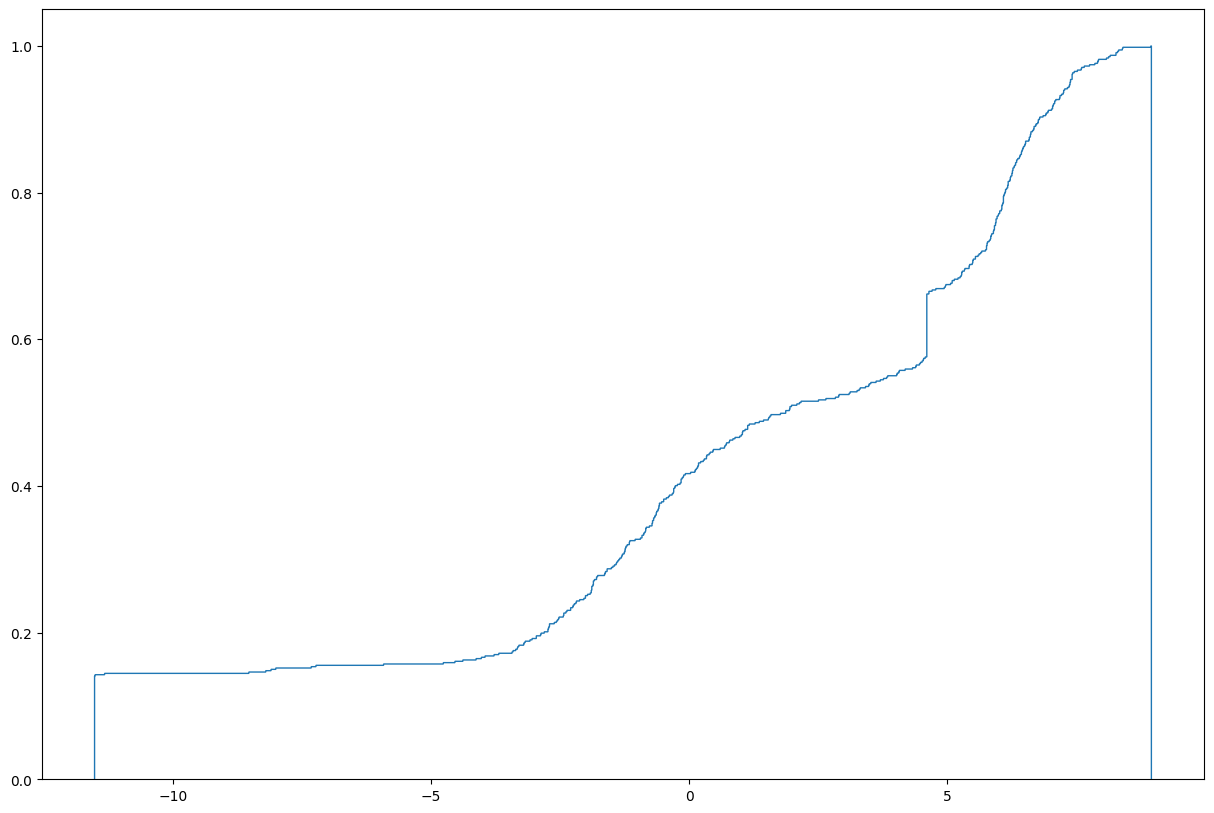

In [28]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=blockSize,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=8,
    n_head=8,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=True,
).to(device)

model_path = "/content/drive/MyDrive/Colab/STAT946_proj/models/diffusym8/1_5_var_set_transformer"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym8/ddim_step_1/1_5_var_set_transformer.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)